## NYC Taxi Trip Duration Prediction using Linear Regression

### Loading Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import mean_squared_error as mse, r2_score

import warnings
warnings.filterwarnings(action = 'ignore')

### Loading Data

In [2]:
data = pd.read_csv('nyc_taxi_trip_duration.csv')

In [3]:
data.shape

(729322, 11)

In [4]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [5]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [6]:
#we can drop dropoff_datetime as it already used to calculate trip_duration
data.drop(columns = ['dropoff_datetime'],inplace=True)

In [7]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

## Variable Identification and Typecasting


In [8]:
# A closer look at the data types present in the data
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

* **id**, **vendor_id**, **passenger_count** and **store_and_fwd_flag** should be converted to category
* **pickup_datetime** should be converted to datetime to extract more variables


In [9]:
# converting to category
data['id'] = data['id'].astype('category')
data['vendor_id'] = data['vendor_id'].astype('category')
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].astype('category')

In [10]:
data['passenger_count'] = data['passenger_count'].astype('category')

## New Features
* **Pickup Day of week**
* **Pickup Month**
* **Pickup Hour**
* **Pickup Part of Day**
* **Distance (in km)**
* **Average speed (in kmph)**

In [11]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_hour'] = data['pickup_datetime'].dt.hour

def partofday(hour):
    if hour in range (7,12):
        return "Morning"
    elif hour in range (12,17):
        return "Afternoon"
    elif hour in range (17,22):
        return "Evening"
    else:
        return "Night"

#adding pickup_partofday to new column
data['pickup_partofday'] = data.apply(lambda x : partofday(x['pickup_hour']),axis = 1)

# calculating distance from latitudes and longitudes
# We can approximate by using distance as the crow flies for now

import geopy.distance

def distance(lat1,long1,lat2,long2):
    coord1 = (lat1,long1) 
    coord2 = (lat2,long2)


    result = geopy.distance.geodesic(coord1, coord2).km
    return result

#adding distance(in km) to new column
data['distance'] = data.apply(lambda x : distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis = 1)

In [12]:
#adding average speed (in kmph) to new column
data['speed'] = data.apply(lambda x : x['distance']/(x['trip_duration']/3600),axis = 1)

In [13]:
# checking new extracted columns using datetime and coordinates
data[['pickup_datetime','pickup_dayofweek','pickup_month','pickup_hour','pickup_partofday','distance','trip_duration','speed']].head()

,pickup_datetime,pickup_dayofweek,pickup_month,pickup_hour,pickup_partofday,distance,trip_duration,speed
0,2016-02-29 16:40:21,0,2,16,Afternoon,1.199770,400,10.797929
1,2016-03-11 23:35:37,4,3,23,Night,4.123945,1100,13.496548
2,2016-02-21 17:59:33,6,2,17,Evening,7.250436,1635,15.964262
3,2016-01-05 09:44:31,1,1,9,Morning,2.358287,1141,7.440694
4,2016-02-17 06:42:23,2,2,6,Night,4.328155,848,18.374244


In [14]:
#we can drop pickup_datetime now as we have extracted everything we need
data.drop(columns = ['pickup_datetime'],inplace=True)
data.dtypes

id                    category
vendor_id             category
passenger_count       category
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag    category
trip_duration            int64
pickup_dayofweek         int64
pickup_month             int64
pickup_hour              int64
pickup_partofday        object
distance               float64
speed                  float64
dtype: object

In [15]:
data['pickup_partofday'] = data['pickup_partofday'].astype('category')
data['pickup_dayofweek'] = data['pickup_dayofweek'].astype('category')
data['pickup_month'] = data['pickup_month'].astype('category')
data['pickup_hour'] = data['pickup_hour'].astype('category')
data.dtypes

id                    category
vendor_id             category
passenger_count       category
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag    category
trip_duration            int64
pickup_dayofweek      category
pickup_month          category
pickup_hour           category
pickup_partofday      category
distance               float64
speed                  float64
dtype: object

### Missing Values

In [16]:
data.isnull().sum()

id                    0
vendor_id             0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_dayofweek      0
pickup_month          0
pickup_hour           0
pickup_partofday      0
distance              0
speed                 0
dtype: int64

No missing values!

## Removing Outliers

In [17]:
# remove the longitude -121 as it is on the complete opposite coast.
data.drop(421819, inplace = True)

In [18]:
data.drop(244913,inplace=True);

In [19]:
data.drop(data.loc[data.speed>200].index,inplace=True);
data.drop(data.loc[(data.passenger_count==0)|(data.passenger_count==7)|(data.passenger_count==9)].index,inplace=True)
data.passenger_count = data.passenger_count.astype('int64')
data.passenger_count = data.passenger_count.astype('category')

In [20]:
data.dtypes

id                    category
vendor_id             category
passenger_count       category
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag    category
trip_duration            int64
pickup_dayofweek      category
pickup_month          category
pickup_hour           category
pickup_partofday      category
distance               float64
speed                  float64
dtype: object

In [21]:
# Let's drop id and speed as these are not useful going forward
data.drop(columns = ['id','speed','pickup_partofday'], inplace = True)

### Preprocessing

Now, before applying linear model such as linear regression, we need to scale the data and keep all features as numeric strictly. 


### Dummies with Multiple Categories

In [22]:
# Convert categorical variables to one hot encoded features
data = pd.get_dummies(data, drop_first = True)

In [23]:
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,vendor_id_2,passenger_count_2,passenger_count_3,passenger_count_4,...,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23
0,-73.953918,40.778873,-73.963875,40.771164,400,1.199770,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,-73.988312,40.731743,-73.994751,40.694931,1100,4.123945,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-73.997314,40.721458,-73.948029,40.774918,1635,7.250436,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,-73.961670,40.759720,-73.956779,40.780628,1141,2.358287,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-74.017120,40.708469,-73.988182,40.740631,848,4.328155,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Scaling Numerical Features for Linear Regression

Now, we remember that there are a lot of outliers in the numerical variables. Also, the distributions are skewed for these features. We will take 2 steps to deal with that here:
* Log Transformation
* Standard Scaler

Standard scaling is anyways a necessity when it comes to linear models and we have done that here after doing log transformation on all balance features.

In [24]:
num_cols = ['pickup_latitude','pickup_longitude','dropoff_latitude',
           'dropoff_longitude','distance','trip_duration']

In [25]:
data[num_cols].min()

pickup_latitude      35.310307
pickup_longitude    -77.896019
dropoff_latitude     35.173546
dropoff_longitude   -77.896019
distance              0.000000
trip_duration         1.000000
dtype: float64

In [26]:
for i in num_cols:
    data[i] = np.log(data[i] + 100)

std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [27]:
data_og = data.copy()
data = data.drop(columns = num_cols)

In [28]:
scaled.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance,trip_duration
0,0.935278,0.487163,0.570864,0.248150,-0.584842,-0.667868
1,-0.641392,-0.370153,-1.675930,-0.560638,0.201233,0.675984
2,-0.985509,-0.594749,0.681464,0.662863,1.017641,1.241920
3,0.294592,0.294042,0.849717,0.433873,-0.270727,0.727554
4,-1.420159,-1.089134,-0.328877,-0.388488,0.255302,0.314149


In [29]:
data.head()

,vendor_id_2,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,store_and_fwd_flag_Y,pickup_dayofweek_1,pickup_dayofweek_2,pickup_dayofweek_3,...,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
data = pd.concat([data,scaled], axis=1)

In [33]:
data.drop(data.loc[data['vendor_id_2'].isna()].index, inplace = True)

In [34]:
data.drop(data.loc[data['distance'].isna()].index, inplace = True)

In [36]:
data_y = data['trip_duration']
data_x = data.drop(columns = 'trip_duration')

## Model Building and Evaluation Metrics
We will be using two metrics
1. Mean Squared Error
2. Adjusted R2

### Train Test Split to create a validation set

In [37]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(data_x,data_y,test_size=0.2, random_state=69)

## Baseline model

In [38]:
baseline_mean = ytrain.mean()
base_predict = pd.Series([baseline_mean for x in range(len(ytest.index))])

In [39]:
base_mse = mse(ytest, base_predict)
base_mse

1.0066739590332818

In [40]:
base_adjr2 = 0
base_adjr2

0

## Full Linear Regression Model

In [41]:
model = LinearRegression()
model.fit(xtrain, ytrain)
full_predict = model.predict(xtest)

full_mse = mse(ytest, full_predict)
full_r2 = r2_score(ytest, full_predict)

full_adjr2 = 1 - ((1 - full_r2) * (len(ytrain) - 1) / (len(ytrain) - xtrain.shape[1] - 1))
print(full_mse, full_adjr2)

0.5396236987317399 0.4639091951545802


In [42]:
model.coef_

array([ 3.14512394e-03,  2.64963762e-03,  4.83737279e-03, -4.01951965e-04,
       -8.71886223e-03, -5.08529298e-03,  8.37307637e-03,  3.59712886e-03,
        2.38616488e-03,  6.76409699e-03,  1.30815444e-03, -1.07040796e-03,
       -1.35127815e-03,  1.16069266e-03, -4.73018609e-03, -1.94777524e-03,
       -5.43996927e-05, -1.69201108e-03,  9.47985915e-03,  2.39207083e-03,
       -1.42658334e-03, -1.07878216e-02, -1.14623418e-02, -5.65118183e-03,
        3.41544395e-03, -1.09178887e-02, -3.55680192e-03, -5.19040688e-04,
        5.84265907e-03,  2.49728618e-03,  8.16728607e-03, -7.38130448e-03,
       -4.98145424e-03,  3.71266245e-03, -1.72200969e-03,  3.64247227e-03,
        1.33258392e-03,  6.68695829e-04,  5.00698459e-04, -7.05698006e-03,
       -9.41196480e-03,  5.93621617e-02, -1.00830834e-01, -4.85401365e-02,
       -6.26136859e-02,  7.46819847e-01])

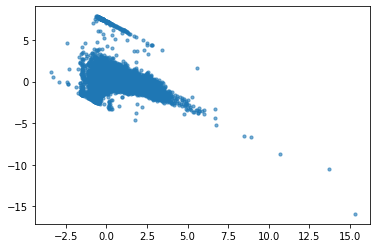

In [43]:
residuals = ytest - full_predict
plt.scatter(x = full_predict, y = residuals, s = 10, alpha = 0.6)

This shows that the data does not have a linear relationship as the residuals have correlation with the fitted values

## Full Ridge Regression Model

In [44]:
def alpha_evaluator_ridge(alpha_list, xtrain, ytrain):
    mse_list = []
    adjr2_list = []
    for alpha_ in alpha_list:
        model = Ridge(alpha = alpha_)
        scores = cross_validate(model, X = xtrain, y = ytrain, cv=6,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

        mse = -scores['test_neg_mean_squared_error'].mean()
        r2 = scores['test_r2'].mean()

        adjr2 = 1 - ((1 - r2) * (len(ytrain) - 1) / (len(ytrain) - xtrain.shape[1] - 1))
        
        mse_list.append(mse)
        adjr2_list.append(adjr2)
        
    return mse_list, adjr2_list

In [45]:
alpha_list = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
mse_list, adjr2_list = alpha_evaluator_ridge(alpha_list, xtrain, ytrain)

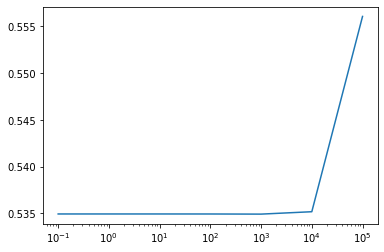

In [46]:
plt.plot(alpha_list, mse_list)
plt.xscale('log')

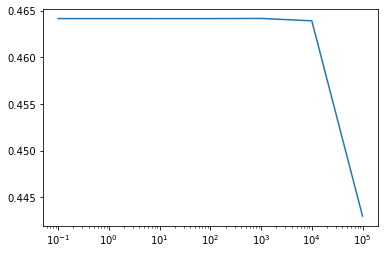

In [47]:
plt.plot(alpha_list, adjr2_list)
plt.xscale('log')

In [48]:
mse_list

[0.5349309873407767,
 0.5349309661663885,
 0.5349307553973988,
 0.5349287385871823,
 0.5349148964145899,
 0.5351713709961463,
 0.5560736473235662]

In [49]:
adjr2_list

[0.4641467865084935,
 0.464146808217189,
 0.4641470243239092,
 0.4641490940215536,
 0.46416343491384904,
 0.46391044455845587,
 0.44297831695528045]

In [50]:
model = Ridge(alpha = 1000.0)
model.fit(xtrain, ytrain)
ridge_predict = model.predict(xtest)

ridge_mse = mse(ytest, ridge_predict)
ridge_r2 = r2_score(ytest, ridge_predict)

ridge_adjr2 = 1 - ((1 - ridge_r2) * (len(ytrain) - 1) / (len(ytrain) - xtrain.shape[1] - 1))
print(ridge_mse, ridge_adjr2)

0.5396583035353988 0.46387481690712995


In [51]:
model.coef_

array([ 3.05738596e-03,  2.65550480e-03,  4.67586793e-03, -3.29091577e-04,
       -8.39653079e-03, -4.80865555e-03,  6.41413939e-03,  3.40730324e-03,
        2.21582278e-03,  6.53890966e-03,  1.16767740e-03, -1.16205416e-03,
       -1.41766730e-03,  1.21986672e-03, -4.60285034e-03, -1.85040455e-03,
        1.36173254e-05, -1.58725465e-03,  9.52410382e-03,  2.79674193e-03,
       -6.73254756e-04, -8.69844871e-03, -9.21595784e-03, -4.60221913e-03,
        3.93571194e-03, -9.86850905e-03, -2.77040663e-03,  1.64175271e-04,
        6.29826280e-03,  3.07188117e-03,  8.56253761e-03, -6.47416910e-03,
       -4.14055489e-03,  4.24747751e-03, -9.92058360e-04,  4.20555945e-03,
        1.97368508e-03,  1.32979257e-03,  1.17266961e-03, -6.16634439e-03,
       -8.43308925e-03,  5.87590022e-02, -9.99352412e-02, -4.85746381e-02,
       -6.20879966e-02,  7.44758381e-01])

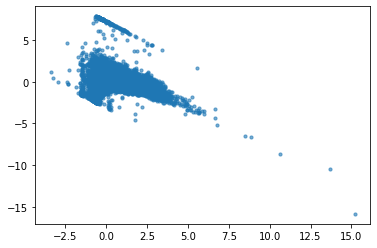

In [52]:
residuals = ytest - ridge_predict
plt.scatter(x = ridge_predict, y = residuals, s = 10, alpha = 0.6)

This shows that the data does not have a linear relationship as the residuals have correlation with the fitted values

## Full Lasso Regression Model

In [53]:
def alpha_evaluator_lasso(alpha_list, xtrain, ytrain):
    mse_list = []
    adjr2_list = []
    for alpha_ in alpha_list:
        model = Lasso(alpha = alpha_)
        scores = cross_validate(model, X = xtrain, y = ytrain, cv=6,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

        mse = -scores['test_neg_mean_squared_error'].mean()
        r2 = scores['test_r2'].mean()

        adjr2 = 1 - ((1 - r2) * (len(ytrain) - 1) / (len(ytrain) - xtrain.shape[1] - 1))
        
        mse_list.append(mse)
        adjr2_list.append(adjr2)
        
    return mse_list, adjr2_list

In [54]:
alpha_list = [0.0001, 0.001, 0.01, 0.1, 1.0]
mse_list, adjr2_list = alpha_evaluator_lasso(alpha_list, xtrain, ytrain)

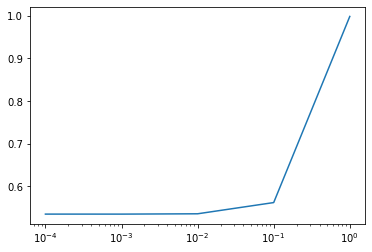

In [55]:
plt.plot(alpha_list, mse_list)
plt.xscale('log')

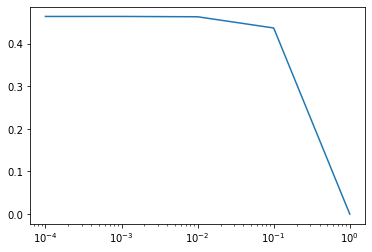

In [56]:
plt.plot(alpha_list, adjr2_list)
plt.xscale('log')

In [57]:
mse_list

[0.5349100086086248,
 0.5348887146747702,
 0.5356525384689791,
 0.5619637006022407,
 0.9983428513046423]

In [58]:
adjr2_list

[0.4641680209509568,
 0.46419021143338335,
 0.46343105324788214,
 0.43707905073031306,
 -0.00010806173363175908]

In [59]:
model = Ridge(alpha = 0.001)
model.fit(xtrain, ytrain)
lasso_predict = model.predict(xtest)

lasso_mse = mse(ytest, lasso_predict)
lasso_r2 = r2_score(ytest, lasso_predict)

lasso_adjr2 = 1 - ((1 - lasso_r2)* (len(ytrain) - 1) / (len(ytrain) - xtrain.shape[1] - 1))
print(lasso_mse, lasso_adjr2)

0.539623698762352 0.4639091951241684


In [60]:
model.coef_

array([ 3.14512385e-03,  2.64963764e-03,  4.83737262e-03, -4.01951878e-04,
       -8.71886189e-03, -5.08529269e-03,  8.37307380e-03,  3.59712866e-03,
        2.38616470e-03,  6.76409676e-03,  1.30815430e-03, -1.07040804e-03,
       -1.35127820e-03,  1.16069273e-03, -4.73018596e-03, -1.94777513e-03,
       -5.43996195e-05, -1.69201096e-03,  9.47986005e-03,  2.39207213e-03,
       -1.42658164e-03, -1.07878183e-02, -1.14623383e-02, -5.65117983e-03,
        3.41544536e-03, -1.09178868e-02, -3.55680024e-03, -5.19039115e-04,
        5.84266041e-03,  2.49728764e-03,  8.16728734e-03, -7.38130268e-03,
       -4.98145250e-03,  3.71266387e-03, -1.72200807e-03,  3.64247372e-03,
        1.33258545e-03,  6.68697374e-04,  5.00700015e-04, -7.05697828e-03,
       -9.41196293e-03,  5.93621610e-02, -1.00830833e-01, -4.85401366e-02,
       -6.26136854e-02,  7.46819845e-01])

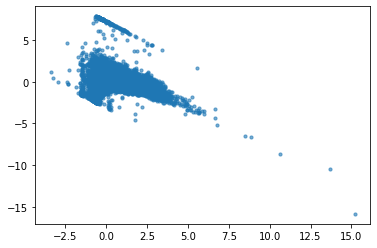

In [61]:
residuals = ytest - ridge_predict
plt.scatter(x = ridge_predict, y = residuals, s = 10, alpha = 0.6)

This shows that the data does not have a linear relationship as the residuals have correlation with the fitted values

### Comparison

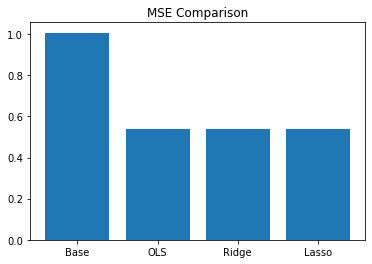

In [62]:
models = ['Base', 'OLS', 'Ridge', 'Lasso']
mse_vals = [base_mse, full_mse, ridge_mse, lasso_mse]

plt.bar(models, mse_vals)
plt.title('MSE Comparison')
plt.show()

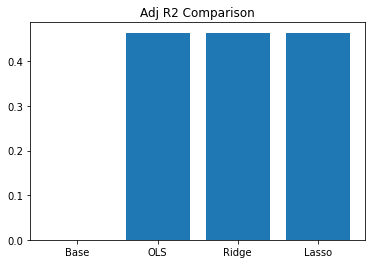

In [63]:
models = ['Base', 'OLS', 'Ridge', "Lasso"]
adjr2_vals = [base_adjr2, full_adjr2, ridge_adjr2, lasso_adjr2]

plt.bar(models, adjr2_vals)
plt.title('Adj R2 Comparison')
plt.show()

The performance of the three models are similar. I will attempt Reverse Feature Elimination on the Lasso Regression Model

### Reverse Feature Elimination or Backward Selection

We have already built a laso regression model using all the features and a separate model using only the baseline mean. We can try using backward feature elimination to check if we can do better. Let's do that next.

### VIF

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF = pd.Series([variance_inflation_factor(xtrain.values,i) for i in range(xtrain.shape[1])], index = xtrain.columns)
VIF

vendor_id_2             2.316581
passenger_count_2       1.208239
passenger_count_3       1.062257
passenger_count_4       1.028841
passenger_count_5       1.141008
passenger_count_6       1.087340
store_and_fwd_flag_Y    1.011719
pickup_dayofweek_1      1.879558
pickup_dayofweek_2      1.910953
pickup_dayofweek_3      1.942763
pickup_dayofweek_4      1.934901
pickup_dayofweek_5      1.939012
pickup_dayofweek_6      1.825683
pickup_month_2          1.874123
pickup_month_3          1.956213
pickup_month_4          1.930489
pickup_month_5          1.916076
pickup_month_6          1.867717
pickup_hour_1           1.259116
pickup_hour_2           1.190243
pickup_hour_3           1.142558
pickup_hour_4           1.101747
pickup_hour_5           1.089548
pickup_hour_6           1.197572
pickup_hour_7           1.340288
pickup_hour_8           1.405681
pickup_hour_9           1.409312
pickup_hour_10          1.401963
pickup_hour_11          1.416546
pickup_hour_12          1.439881
pickup_hou

VIF for all variables is under 5

In [65]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Create the RFE object and rank each feature
model = Lasso(alpha = 0.001)
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(xtrain, ytrain)

RFE(estimator=Lasso(alpha=0.001), n_features_to_select=1)

In [66]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = xtrain.columns
ranking_df['Rank'] = rfe.ranking_

In [67]:
ranked = ranking_df.sort_values(by=['Rank'])

In [68]:
ranked = ranked.reset_index().drop(columns = ['index'])

In [69]:
ranked

,Feature_name,Rank
0,distance,1
1,pickup_longitude,2
2,dropoff_longitude,3
3,pickup_latitude,4
4,dropoff_latitude,5
5,pickup_hour_23,6
6,pickup_hour_22,7
7,pickup_hour_21,8
8,pickup_hour_20,9
9,pickup_hour_19,10


The distance. coordinates and pickup hour features are proving to be very important as can be seen from the table. The RFE function can also be used to select features. Lets select the top 28 features (approx half) from this table and check score.

In [76]:
cols = ranked['Feature_name'][:28].values

In [77]:
xtrain_rfe = xtrain[cols]
xtest_rfe = xtest[cols]

In [78]:
model = Lasso(alpha = 0.001)
model.fit(xtrain_rfe, ytrain)
rfe_predict = model.predict(xtest_rfe)

rfe_mse = mse(ytest, rfe_predict)
rfe_r2 = r2_score(ytest, rfe_predict)

rfe_adjr2 = 1 - ((1 - rfe_r2) * (len(ytrain) - 1) / (len(ytrain) - xtrain_rfe.shape[1] - 1))
print(rfe_mse, rfe_adjr2)

0.5396334181071912 0.46391608251661876


## Final Comparison

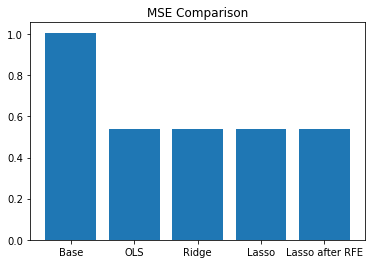

In [79]:
models = ['Base', 'OLS', 'Ridge', 'Lasso', 'Lasso after RFE']
mse_vals = [base_mse, full_mse, ridge_mse, lasso_mse, rfe_mse]

plt.bar(models, mse_vals)
plt.title('MSE Comparison')
plt.show()

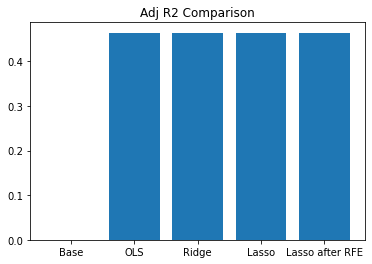

In [80]:
models = ['Base', 'OLS', 'Ridge', 'Lasso', 'Lasso after RFE']
adjr2_vals = [base_adjr2, full_adjr2, ridge_adjr2, lasso_adjr2, rfe_adjr2]

plt.bar(models, adjr2_vals)
plt.title('Adj R2 Comparison')
plt.show()

The performance of all models is much better than the base model but we have been unable to improve performance compared to the simple full Linear Regression model

Also, residuals have correlation with fitted values which shows that the data is not fit for using Linear Regression.